In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile


import re
import warnings
warnings.filterwarnings("ignore")


zip_file_path = r'/content/drive/MyDrive/Colab Notebooks/datasets/train.tsv.zip'  # Replace 'actual_file_name.zip' with the correct filename
extract_to_path = r'/content/drive/MyDrive/Colab Notebooks/datasets/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

zip_file_path = r'/content/drive/MyDrive/Colab Notebooks/datasets/test.tsv.zip'  # Replace 'actual_file_name.zip' with the correct filename

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)



In [3]:
# Cargar datos desde archivos CSV
train = pd.read_csv(extract_to_path + '/train.tsv', sep='\t')  # Handle potential errors and use tab as delimiter
test = pd.read_csv(extract_to_path + '/test.tsv', sep='\t')  # Use the correct path and handle errors

print(train.head())
print(test.head())


   PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2  
   PhraseId  SentenceId                                             Phrase
0    156061        8545  An intermittently pleasing but mostly routine ...
1    156062        8545  An intermittently pleasing but mostly routine ...
2    156063        8545                                                 An
3    156064        8545  intermittently pleasing but mostly routine effort
4    156065        8545         intermittently pleasing but mostly

Utilizando diversos clasificadores

In [4]:
# 1. Importación de bibliotecas

import nltk
import random
from nltk.corpus import movie_reviews
# Descargar el recurso 'punkt'
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Checking the shape of all data
print("train dataset: ",train.shape)
print("test dataset: ",test.shape)

train dataset:  (156060, 4)
test dataset:  (66292, 3)


In [6]:
# Checking for null values on the train dataset

train.isnull().sum()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [7]:
# Creating a new column with a 'for loop and if statement' from the Sentiment column

Sentiment_phrase =[]

for row in train['Sentiment']:
    if row == 0:
        Sentiment_phrase.append('negative')
    elif row == 1:
        Sentiment_phrase.append('somewhat negative')
    elif row == 2:
        Sentiment_phrase.append('neutral')
    elif row == 3:
        Sentiment_phrase.append('somewhat positive')
    elif row == 4:
        Sentiment_phrase.append('positive')
    else:
        Sentiment_phrase.append('Failed')


train['Sentiment_phrase'] = Sentiment_phrase

In [8]:
train.head()

# Count of Sentiment Column

train['Sentiment'].value_counts()

,count
Sentiment,
2,79582
3,32927
1,27273
4,9206
0,7072


In [9]:
# Count of Sentiment Phrase Column

senti_phrase_count = pd.value_counts(train['Sentiment_phrase'].values)
senti_phrase_count

,count
neutral,79582
somewhat positive,32927
somewhat negative,27273
positive,9206
negative,7072


Visualization and finding nteresting insights

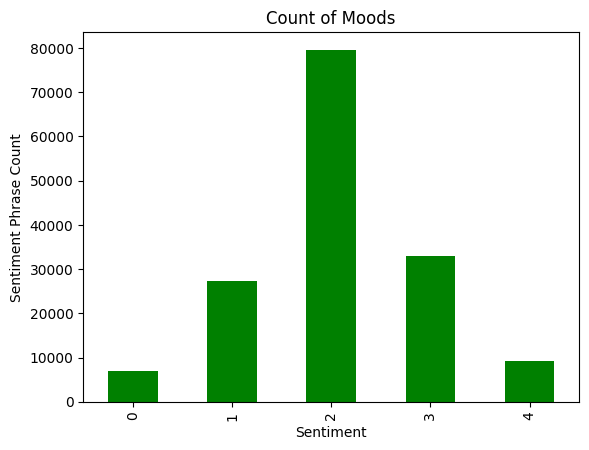

In [10]:
# A quick visualization of the sentiment phrase to see the distribution


train['Sentiment'].value_counts().sort_index().plot(kind='bar', color= 'green')
plt.ylabel('Sentiment Phrase Count')
plt.xlabel('Sentiment')
plt.title('Count of Moods');

In [11]:


# word_count in the phrase column

word_counts = train['Phrase'].apply(lambda x: len(x.split()))

word_counts.describe()
print(train['Sentiment'].value_counts(normalize=True).sort_index())



Sentiment
0    0.045316
1    0.174760
2    0.509945
3    0.210989
4    0.058990
Name: proportion, dtype: float64


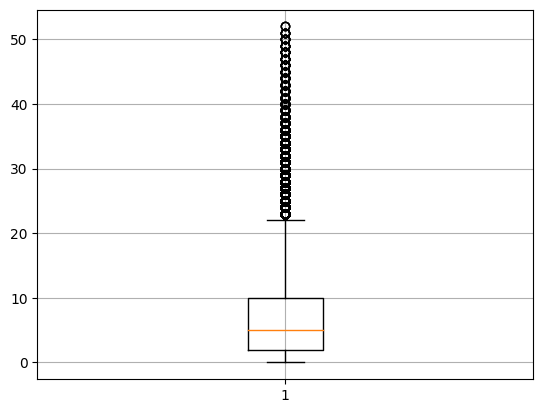

In [12]:
plt.boxplot(word_counts.values)
plt.grid(True)
plt.show()

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Descargar recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


stemmer  = SnowballStemmer(language='english') #setup for english language
stop_words = stopwords.words('english') # defining stop_words for english language
stop_words.remove('not') # removing not from the stop_words list as it contains value in negative movies reviews
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
#function to create tokenizer
def tokenize(text):
    return [stemmer.stem(token) for token in word_tokenize(text)]

#  Lets test the tokenize function
tokenize("Kaggle is a great place to learn data science")

['kaggl', 'is', 'a', 'great', 'place', 'to', 'learn', 'data', 'scienc']

Text Pre-processing

In [15]:
# Let's create a function to clean the Phrase column

def data_preprocess(Phrase):
    Phrase = re.sub(re.compile('<.*?>'), '', Phrase) #removing html tags if any
    Phrase =  re.sub('[^A-Za-z0-9]+', ' ', Phrase) #taking only words
    Phrase = Phrase.lower()   # making all phrases lower case
    tokens = nltk.word_tokenize(Phrase) # converts Phrases to tokens
    Phrase = [word for word in tokens if word not in stop_words] #removing stop words
    Phrase = [lemmatizer.lemmatize(word) for word in Phrase]   # lemmatization
    Phrase = ' '.join(Phrase)  # join words in preprocessed Phrase

    return Phrase

In [16]:

train['Preprocessed_phrase'] = train['Phrase'].apply(lambda Phrase: data_preprocess(Phrase))
train.head()


,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_phrase,Preprocessed_phrase
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative,series escapade demonstrating adage good goose...
1,2,1,A series of escapades demonstrating the adage ...,2,neutral,series escapade demonstrating adage good goose
2,3,1,A series,2,neutral,series
3,4,1,A,2,neutral,
4,5,1,series,2,neutral,series


In [17]:
# Testing the tokenization fuction on a differnt text string
data_preprocess('I am going to buy a big car tomorrow and i am serious about it')

'going buy big car tomorrow serious'

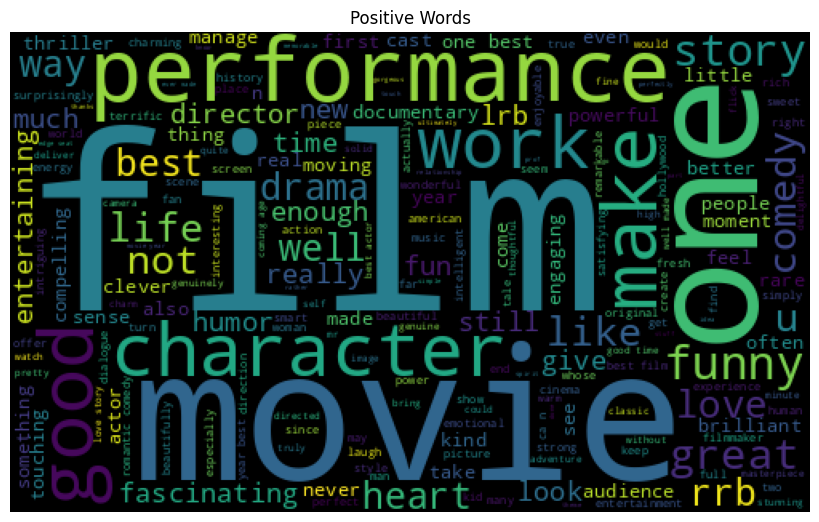

In [18]:
from wordcloud import WordCloud

words_list = train[train['Sentiment_phrase']=='positive']['Preprocessed_phrase'].unique().tolist()
positive_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=500, height = 300,
                  stopwords=stop_words).generate(positive_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Positive Words')
plt.show()



Visualising the Negative reviews in word cloud¶


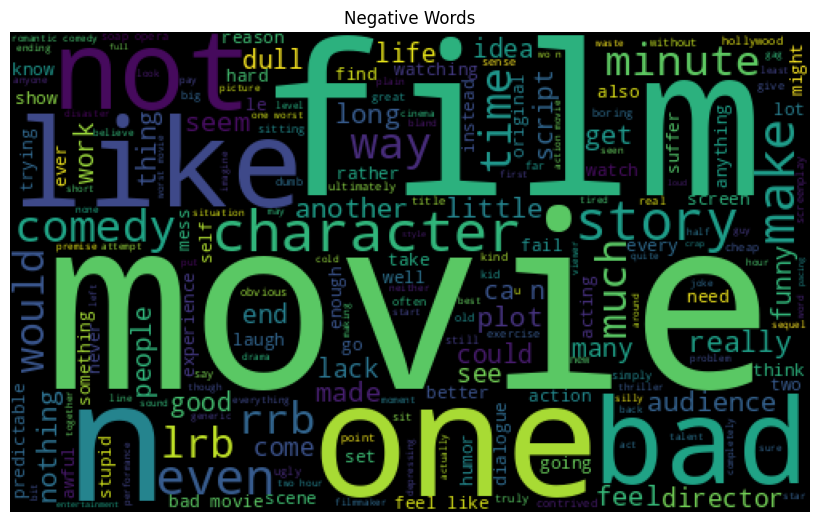

In [19]:
words_list = train[train['Sentiment_phrase']=='negative']['Preprocessed_phrase'].unique().tolist()
positive_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=500, height = 300,
                  stopwords=stop_words).generate(positive_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Negative Words')
plt.show()

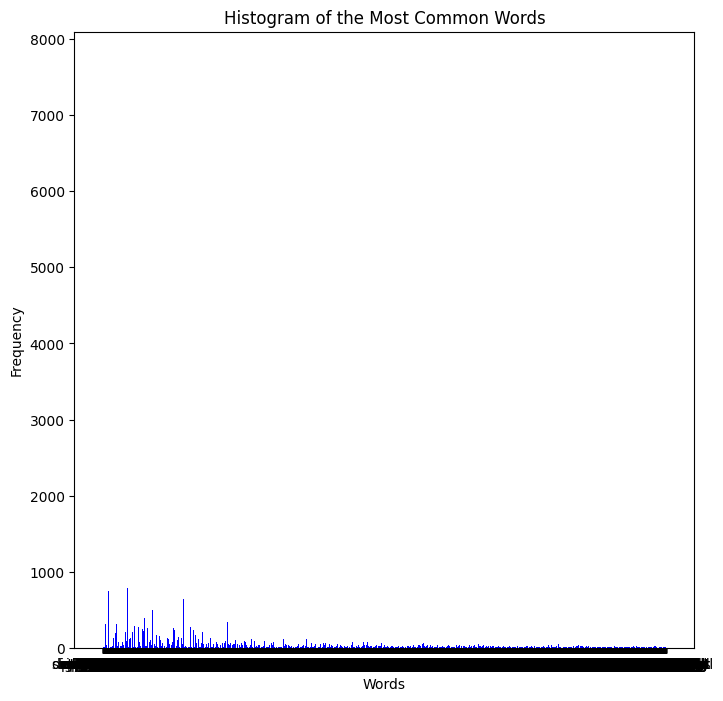

In [20]:
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Assuming 'train' is a DataFrame with columns 'Sentiment_phrase' and 'Preprocessed_phrase'
# Adjust column names if they are different
all_words = []
stop_words = set(stopwords.words('english'))

# Iterate over the DataFrame rows
for index, row in train.iterrows():
    text = row['Preprocessed_phrase']  # Access the 'Preprocessed_phrase' column
    #label = row['label']  # Access the 'label' column (if needed)
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    all_words.extend(words)

# Rest of the code remains the same...
word_freq = Counter(all_words)

# Extract words and their frequencies for the bar chart
words = list(word_freq.keys())
frequencies = list(word_freq.values())

# Generar el histograma
plt.figure(figsize=(8, 8))
plt.bar(words, frequencies, color='blue') # Use extracted words and frequencies
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Histogram of the Most Common Words')
plt.show()

In [21]:
from sklearn.model_selection import train_test_split

train_df = train.copy()
y = train_df['Sentiment'].values
train_df.drop(['Sentiment'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, stratify=y)

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (124848, 5) (124848,)
Test data: (31212, 5) (31212,)




Vectorizing the Text Data

In the next step, we will transfer the pre-processed phrase column to a vector representation. The vector representations allows us to train a model based on numerical representations. In this case, we will use CountVectorizer.

Bag of Word(BOW)


In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_train_phrase_bow = vectorizer.fit_transform(X_train['Preprocessed_phrase'])
X_test_phrase_bow = vectorizer.transform(X_test['Preprocessed_phrase'])

print('X_train_phrase_bow shape: ', X_train_phrase_bow.shape)
print('X_test_phrase_bow shape: ', X_test_phrase_bow.shape)



X_train_phrase_bow shape:  (124848, 13731)
X_test_phrase_bow shape:  (31212, 13731)


In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB()
clf.fit(X_train_phrase_bow, y_train)

y_pred = clf.predict(X_test_phrase_bow) #prediction from model
print('Test Accuracy: ', accuracy_score(y_test, y_pred))


Test Accuracy:  0.6128091759579649


In [ ]:
# 6. Entrenamiento con varios clasificadores

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier  # Requires additional dependencies, might be computationally expensive
import matplotlib.pyplot as plt

# Definir los modelos a comparar

models = {
    'Naive Bayes (Multinomial)': MultinomialNB(),
    #'Naive Bayes (Gaussian)': GaussianNB(),
    #'Naive Bayes (Bernoulli)': BernoulliNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM (SVC)': SVC(probability=True),
    #'SVM (NuSVC)': NuSVC(probability=True),
    #'SVM (LinearSVC)': LinearSVC(),  # Might need to adjust parameters for multiclass
    'Logistic Regression': LogisticRegression(max_iter=200),
    'SGD Classifier': SGDClassifier(),
    #'Perceptron': Perceptron(),
    #'Passive Aggressive': PassiveAggressiveClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    #'AdaBoost': AdaBoostClassifier(),
    #'Bagging Classifier': BaggingClassifier(),
    #'Extra Trees': ExtraTreesClassifier(),
    #'K Neighbors': KNeighborsClassifier(),
    #'Radius Neighbors': RadiusNeighborsClassifier(),
    #'MLP Classifier': MLPClassifier(),
    #'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Gaussian Process': GaussianProcessClassifier()  # Uncomment if you have the necessary dependencies
}

results = []

for model_name, model in models.items():
    # Pass the vectorized data to the fit method, not the original DataFrame
    if model_name == 'Naive Bayes (Gaussian)':
        model.fit(X_train_phrase_bow.toarray(), y_train)  # Convert to dense array for GaussianNB
        predicted_labels = model.predict(X_test_phrase_bow.toarray())  # Convert to dense array for prediction
    else:
        model.fit(X_train_phrase_bow.toarray(), y_train)
        predicted_labels = model.predict(X_test_phrase_bow.toarray())

    accuracy = accuracy_score(y_test, predicted_labels)  # Compare with true labels y_test
    # Use 'weighted' averaging for multiclass F1-score
    f1 = f1_score(y_test, predicted_labels, average='weighted')
    results.append((model_name, accuracy, f1))
    print(f"{model_name} - Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")

    # Create and display confusion matrix
   # cm = confusion_matrix(y_test, predicted_labels)
   # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
   # disp.plot() # Remove the title argument
   # plt.title(f"Confusion Matrix for {model_name}") # Set the title using plt.title()
   # plt.show()

# Extract results for plotting
model_names, accuracies, f1_scores = zip(*results)

# Plot the results
plt.figure(figsize=(16, 6))  # Increased figure width for better display
plt.bar(model_names, accuracies, label='Accuracy', alpha=0.7)
plt.bar(model_names, f1_scores, label='F1 Score', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Performance Comparison of Classification Models')
plt.legend()
plt.ylim([0, 1])  # Set y-axis limits for better visualization
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

Naive Bayes (Multinomial) - Accuracy: 0.61, F1 Score: 0.60


In [1]:
# ... (your previous code for model training and evaluation)

# New cell for confusion matrix, error, ROC, and AUC

# Choose a specific model to analyze (replace 'Model Name' with the actual name)
selected_model_name = 'Logistic Regression'

# Find the results for the selected model
selected_model_results = next((r for r in results if r[0] == selected_model_name), None)

if selected_model_results:
    model_name, accuracy, f1, error_rate, fpr, tpr, roc_auc = selected_model_results

    # Get the trained model (you might need to retrain it if not stored)
    model = models[selected_model_name]
    model.fit(X_train_phrase_bow, y_train)  # Or use the previously trained model if available
    predicted_labels = model.predict(X_test_phrase_bow)

    # ... (your code for confusion matrix and ROC AUC)

    # Calculate Errors
    errors = y_test != predicted_labels  # Boolean array indicating incorrect predictions

    # Histogram of Errors
    plt.figure()
    plt.hist(errors.astype(int), bins=2, edgecolor='black')  # Convert boolean to 0 and 1 for histogram
    plt.xticks([0, 1], ['Correct', 'Incorrect'])
    plt.xlabel('Prediction Outcome')
    plt.ylabel('Number of Samples')
    plt.title(f'Error Distribution for {model_name}')
    plt.show()

else:
    print(f"Model '{selected_model_name}' not found in results.")

NameError: name 'results' is not defined

In [ ]:
# Choose a specific model to analyze (replace 'Model Name' with the actual name)
selected_model_name = 'Logistic Regression'

# Find the results for the selected model
selected_model_results = next((r for r in results if r[0] == selected_model_name), None)

if selected_model_results:
    model_name, accuracy, f1, error_rate, fpr, tpr, roc_auc = selected_model_results

    # Get the trained model (you might need to retrain it if not stored)
    model = models[selected_model_name]
    model.fit(X_train_phrase_bow, y_train)  # Or use the previously trained model if available
    predicted_labels = model.predict(X_test_phrase_bow)

    # Confusion Matrix
    cm = confusion_matrix(y_test, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    # Error Rate
    print(f"Error Rate for {model_name}: {error_rate:.2f}")

    # ROC and AUC
    if fpr is not None and tpr is not None:
        plt.figure()
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print(f"ROC AUC not available for {model_name}")

else:
    print(f"Model '{selected_model_name}' not found in results.")